# **Non-negative Matrix Factorization - An Implementation and Experimentation**
### CSC 466-1 Knowledge Discovery from Data, Winter 2020 - Final Project
#### Andrew Kesheshian, Griffin Johnson, Quinn Coleman

## **Background**

(insert introduction and background on NMF here)

## **Implementation**

In [99]:
import numpy as np
from sklearn.preprocessing import normalize

In [100]:
# If I don't normalize the basis vectors, transformed values upper limit ~20 on average by sight
# If I do, upper limit ~15 on average by sight

class OurNMF:
    def __init__(self, n_components, learn_iter=200):
        self.n_components_ = n_components
        self.learn_iter_ = learn_iter
        
    # Private method - core functionality
    def __nmf(self, input_df):
        input_matrix = input_df.to_numpy().T
        activations = np.random.rand(self.n_components_, input_matrix.shape[1])
        basis_vectors = np.random.rand(input_matrix.shape[0], self.n_components_)

#         print('Before normalization')
#         print(basis_vectors)
        basis_vectors = normalize(basis_vectors)
#         print('After normalization')
#         print(basis_vectors)

        ones = np.ones(input_matrix.shape)
    
        for i in range(self.learn_iter_):
            activations *= ((basis_vectors.T @ (input_matrix / (basis_vectors @ activations))) / (basis_vectors.T @ ones))
            basis_vectors *= (((input_matrix / (basis_vectors @ activations)) @ activations.T) / (ones @ activations.T))
            
#             if i == 0:
#                 print('Before normalization')
#                 print(basis_vectors)
            basis_vectors = normalize(basis_vectors)
#             if i == 0:
#                 print('After normalization')
#                 print(basis_vectors)
            
        return basis_vectors.T, activations.T
    
    # Public methods
    # Useless function - similar to scikit-learn, but call fit_transform to get transformed values back
    def fit(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        
    def fit_transform(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        return self.trans_vals_


## **Validate our Implementation**
Let's validate our implementation of NMF by comparing its results with the NMF method provided by a trusted and widely-used machine learning library.

This library is called [scikit-learn](https://scikit-learn.org/stable/) and its NMF documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).

***Note -- Scikit-Learn Documentation Error:***
On the NMF documentation page, variable names *W* and *H* are swapped which can be very **misleading**. They call *W* the transformed data, and *H* the factorization matrix (dictionary elements). In reality, *W* is this factorization matrix, and *H* is the transformed data *(no documentation is perfect, even for scikit-learn)*.

#### **Dataset Creation**
To begin, let's make a dataset for our NMFs. We use another python library, [pandas](https://pandas.pydata.org/), to handle datasets.

In [101]:
import pandas as pd

dummy_data = [{'A': 1.00, 'B': 'K', 'C': 3, 'D': 9, 'E': 43.76, 'ans': 1},
              {'A': 0.99, 'B': 'L', 'C': 3, 'D': 8, 'E': 43.45, 'ans': 0},
              {'A': 0.54, 'B': 'M', 'C': 0, 'D': 23, 'E': 54.65, 'ans': 1},
              {'A': 1.00, 'B': 'M', 'C': 0, 'D': 12, 'E': 40.15, 'ans': 0},
              {'A': 0.32, 'B': 'L', 'C': 1, 'D': 12, 'E': 89.04, 'ans': 1},
              {'A': 0.43, 'B': 'L', 'C': 4, 'D': 11, 'E': 49.04, 'ans': 0},
              {'A': 0.99, 'B': 'M', 'C': 1, 'D': 10, 'E': 34.54, 'ans': 0}]

dummy_df = pd.DataFrame(dummy_data)
# Transform categorical features ('B') into quantitative ones ('K', 'L', 'M') via get_dummies (one-hot encoding)
quant = pd.get_dummies(dummy_df['B'])
labels = dummy_df['ans']
dummy_df = dummy_df.drop('B', axis=1).drop('ans', axis=1)
dummy_df = pd.concat((dummy_df, quant, labels), axis=1)
dummy_df

,A,C,D,E,K,L,M,ans
0,1.00,3,9,43.76,1,0,0,1
1,0.99,3,8,43.45,0,1,0,0
2,0.54,0,23,54.65,0,0,1,1
3,1.00,0,12,40.15,0,0,1,0
4,0.32,1,12,89.04,0,1,0,1
5,0.43,4,11,49.04,0,1,0,0
6,0.99,1,10,34.54,0,0,1,0


#### **Comparison**
A good way to see if our NMF works is by performing a common use case for dimensionality reduction: visualizing data.

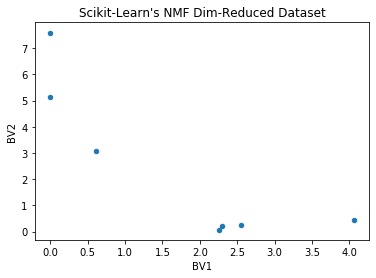

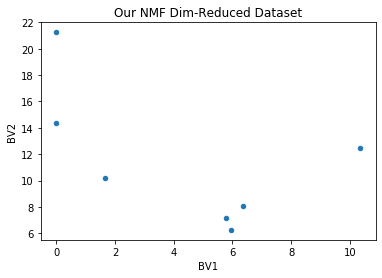

In [138]:
%matplotlib inline
from sklearn.decomposition import NMF

sklearn_nmf = NMF(n_components=2, init='random', solver='mu', beta_loss='kullback-leibler')
our_nmf = OurNMF(n_components=2)

sklearn_trans_df = pd.DataFrame(sklearn_nmf.fit_transform(dummy_df), columns=['BV1', 'BV2'])
our_trans_df = pd.DataFrame(our_nmf.fit_transform(dummy_df), columns=['BV1', 'BV2'])

# display(sklearn_trans_df)
# display(our_trans_df)

sklearn_trans_df.plot.scatter(x='BV1', y='BV2', title='Scikit-Learn\'s NMF Dim-Reduced Dataset')
our_trans_df.plot.scatter(x='BV1', y='BV2', title='Our NMF Dim-Reduced Dataset')

This is great! The data on both charts look similar, which means that both our and scikit-learn's NMF find the same way to represent this data in lower dimension. 👏

*If you don't see a similarity between plots and the axes look flipped:* Run the previous code cell a couple more times until they match. This happens because in NMF each basis vector equally contributes to recreating the dataset, so their ordering isn't meaningful, thus not needing consistency. We just want to see when the basis vector set from our NMF is in the same order as scikit-learn NMF's basis vector set - when this happens, the transformed values corresponding to a basis vector will appear on the same axis as the other chart's axis.